# Homework 2: Hypothesis Testing & Regression

Jake Dame

29 May 2024

CS 6017: Data Analytics & Visualization

Dr. Ben Jones

## Part 1: A/B Hypothesis Testing

### Establishment of test statistic

**The two-proportion $z$-test (pooled for $H_0: p_1 = p_2$):**

$$
z =
\frac
{ (\hat{p_1} - \hat{p_2}) }
{
    \sqrt
    {
        \hat{p}(1 - \hat{p})( \frac{1}{n_1} + \frac{1}{n_2} )
    }
}
$$

**where:**

$$
\hat{p} =
\frac
{x_1 + x_2}
{n_1 + n_2}
$$

**with assumptions:**

$$
n_1p_1 > 5 \text{ and } n_1(1-p_1) > 5 \text{ and } n_2p_2 > 5 \text{ and } n_2(1-p_2) > 5
$$

### Forming Hypotheses

Our null hypothesis is "There is no difference between *logo A* and *logo B*.":

$$
H_0: p_1 = p_2
$$

Our alternative hypothesis is "There is a difference between *logo A* and *logo B*.":

$$
H_a: p_1 ≠ p_2
$$

### Calculating Values

#### Calculate $z$-value:

**Symbols:**

<div style="text-align: center;">

$x_1$, $x_2$ = number of successes (i.e. clicks) for *logo A*, *logo B*

$p_1$, $p_2$ = estimated sample proportion for *logo A*, *logo B*

$\hat{p}$ = estimated pooled proportion

$n$ = range

$z$ = $z$-value

$p$ = $p$-value

</div>

**First, we will calculate the individual proportions $\hat{p}'s$:**

<div style="text-align: center;">

$p_1 = \frac{500}{1000} = \frac{5}{10} = 0.5$

$p_2 = \frac{550}{1000} = \frac{11}{20} = 0.5$

</div>

**Then the pooled proportion $\hat{p}$:**

<div style="text-align: center;">

$x_1 = 500$

$x_2 = 550$

$n_1 \text{, } n_2 = 1000$

</div>

$$
\hat{p} =
\frac
{500 + 550}
{1000 + 1000}
= 
\frac{1050}{2000}
=
\frac{21}{40}
=
0.525
$$

**Next, we plug in the rest of the values and evaluate to get our $z$-value:**

$$
z =
\frac
{ (0.5 - 0.55) }
{
    \sqrt
    {
        0.525(1 - 0.525)( \frac{1}{1000} + \frac{1}{1000} )
    }
}
=
\frac
{ -0.05 }
{
    \sqrt
    {
        0.525(0.475)(0.002)
    }
}
=
\frac
{-0.05}
{ \sqrt{0.00049875} }
=
\frac
{-0.05}
{0.022332711434127295}
=
-2.2388683142
$$

#### $z$-value result:

$$
z = -2.2388683142
$$

#### Calculate $p$-value:

**Using the normal distribution, we can calculate:**

$$
p = F(z) = \int_{-\infty}^z f(z)dz
$$

which we will let a library function do:

In [75]:
from scipy.stats import norm

p_value = norm.cdf(-2.2388683142)
p_value

0.0125822428501015

#### $p$-value result:

$$
p = 0.0125822428501015 \text{ or } ≈ 1.25\%
$$

### Conclusion

We will now compare the $p$-value...

#### ...with $\alpha = .05$

If our significance is 5%:
- We will **reject** $H_0$ (in favor of $H_a$) because $p$ < $\alpha$.
- This translates to: "The observed data/relationships are statistically significant, and *logo A* **may** be different than *logo B*."

#### ...with $\alpha = .01$

If our significance is 1%:
- We will **fail to reject** $H_0$ because $p$ > $\alpha$.
- This translates to: "There observed data/relationships are statistically insignificant, and *logo A* is no different than *logo B*."

## Part 2: Regression of Real Estate Data

### Task 1: Import the Data

In [76]:
# Setup

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from pandas.plotting import scatter_matrix

In [77]:
# Read in .csv files separately

df_csv_1 = pd.read_csv("realEstate1.csv")
df_csv_2 = pd.read_csv("realEstate2.csv")

# Concatenate into one data frame

df = pd.concat( [df_csv_1, df_csv_2] )

### Task 2: Clean the Data

In [78]:
# Keep only houses with prices $200k-1000k

df = df[ (df['LstPrice'] < 1_000_000) & (df['LstPrice'] > 200_000) ] # pandas --> '()' to group, '&' to connect

# Keep only columns with really price-affecting qualities

df = df[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]

In [79]:
# Examine data types

df.dtypes

Acres        float64
Deck           int64
GaragCap       int64
Latitude     float64
Longitude    float64
LstPrice       int64
Patio          int64
PkgSpacs       int64
PropType      object
SoldPrice      int64
Taxes          int64
TotBed       float64
TotBth       float64
TotSqf        object
YearBlt        int64
dtype: object

In [80]:
# Convert 'TotSqf' to integer type

# It will complain about this if we don't first remove the commas from square footages > 999

print( "['TotSqf'] before conversion: ", df['TotSqf'].dtype)

df['TotSqf'] = df['TotSqf'].str.replace(',', '').astype(int)

print( "['TotSqf'] after conversion: ", df['TotSqf'].dtype)

['TotSqf'] before conversion:  object
['TotSqf'] after conversion:  int64


In [81]:
# Create 'Prop_Type_num' column with integer values of 'PropType' column after converting:
#   - all 'Single Family' string values in PropType with the '1'
#   - all 'Condo' or 'Townhouse' string values in PropType with the integer '0'

# We can easily use a lambda function here in conjunction with the pandas .apply() method
#   on a column

f = lambda _: 1 if _ == 'Single Family' else 0

df['Prop_Type_num'] = df['PropType'].apply(f)

df[['Prop_Type_num', 'PropType']]

,Prop_Type_num,PropType
0,1,Single Family
1,0,Condo
2,1,Single Family
3,1,Single Family
5,0,Condo
...,...,...
143,1,Single Family
144,0,Condo
145,0,Condo
146,1,Single Family


In [82]:
# Remove erroneous longitudes

# https://www.unitedstateszipcodes.org/84103/ says 84103 has:
#   a longitude of -111.85
#   a radius of ≈ 5 miles

# true_longitude = -111.85

# One would need to convert that miles-radius into seconds-radius to longitude-decimal radius to compute MOE East/West
# Which, according to google search, is kind of a nightmare

# ChatGPT says this translates to ≈ 0.0725 in terms of ±5 miles East(-)/West(+)

# MOE = 0.0725

# 45 mins later and I think I was originally just being asked to get rid of the one erroneous 0 value.

# df = df[ (df['Longitude'] < true_longitude + MOE) & (df['Longitude'] > true_longitude - MOE) ]

In [83]:
# Remove erroneous values from 'Longitude'

# If you are interested to know how I came up with the '-111' magic number, you can read 
#   the commented out cell above. That was until I realized it was really easy to do just by
#   eyeballing the data.

print( "'Longitude' before cleaning:", df['Longitude'].size )
df = df[ df['Longitude'] < -111 ]
print( "'Longitude' after cleaning:", df['Longitude'].size )

'Longitude' before cleaning: 260
'Longitude' after cleaning: 259


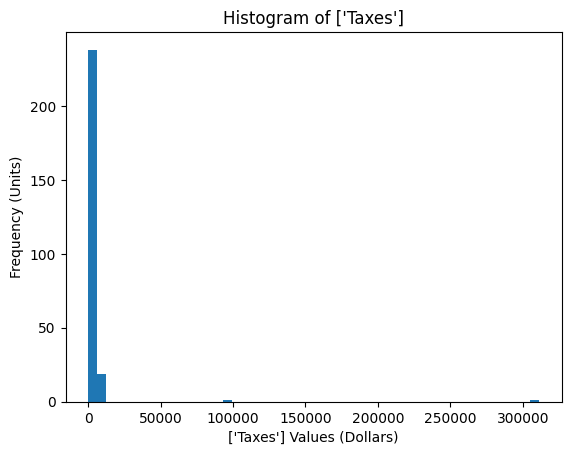

In [84]:
# Remove erroneous 'Taxes' values

# I did this by plotting all of the values in a histogram and just eyeballing the outliers

plt.hist(df['Taxes'], bins=50)
plt.title('Histogram of [\'Taxes\']')
plt.xlabel('[\'Taxes\'] Values (Dollars)')
plt.ylabel('Frequency (Units)')

plt.show()

In [85]:
# So we will just omit things above the $50k mark

print( "'Taxes' before cleaning:", df['Taxes'].size )
df = df[df['Taxes'] < 50000]
print( "'Taxes' after cleaning:", df['Taxes'].size )


'Taxes' before cleaning: 259
'Taxes' after cleaning: 257


### Task 3: Exploratory data analysis

In [86]:
print( "Number of rows, columns: ", df.shape, '\n' )
print(df.describe() )

Number of rows, columns:  (257, 16) 

            Acres        Deck    GaragCap    Latitude   Longitude  \
count  257.000000  257.000000  257.000000  257.000000  257.000000   
mean     0.131051    0.750973    1.276265   40.777555 -111.875749   
std      0.123753    1.246969    0.975051    0.005825    0.013946   
min      0.000000    0.000000    0.000000   40.769424 -111.913645   
25%      0.050000    0.000000    0.000000   40.772489 -111.886688   
50%      0.110000    1.000000    1.000000   40.775852 -111.874094   
75%      0.160000    1.000000    2.000000   40.782180 -111.866018   
max      0.690000   16.000000    5.000000   40.791059 -111.843083   

            LstPrice       Patio    PkgSpacs      SoldPrice        Taxes  \
count     257.000000  257.000000  257.000000     257.000000   257.000000   
mean   463404.525292    0.832685    1.046693  450866.692607  3024.774319   
std    197317.157047    3.397957    1.587844  187524.462691  1664.202506   
min    205000.000000    0.000000    

#### Response:

**"Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable."**

There are 257 rows (after cleaning the date), which represent 257 different listings of properties in the 84103 zip code in SLC.

There are 16 columns/attributes/variable that each listing has. They relate to aspects of the property that will probably affect the value (in dollars) of the property.

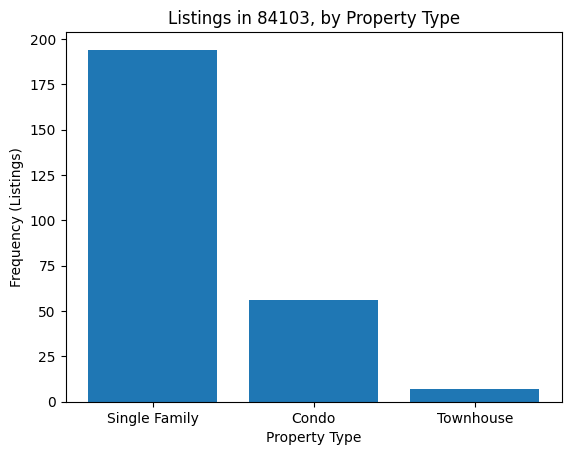

In [87]:
# Bar chart of frequencies of houses vs townhouses vs condos

# Filter by "Single Family"/"Condo"/"Townhouse"; count

num_houses = df[df['PropType'] == 'Single Family'].shape[0]
num_condos = df[df['PropType'] == 'Condo'].shape[0]
num_townhouses = df[df['PropType'] == 'Townhouse'].shape[0]

plt.bar(['Single Family', 'Condo', 'Townhouse'], [num_houses, num_condos, num_townhouses])

plt.title('Listings in 84103, by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Frequency (Listings)')

plt.show()

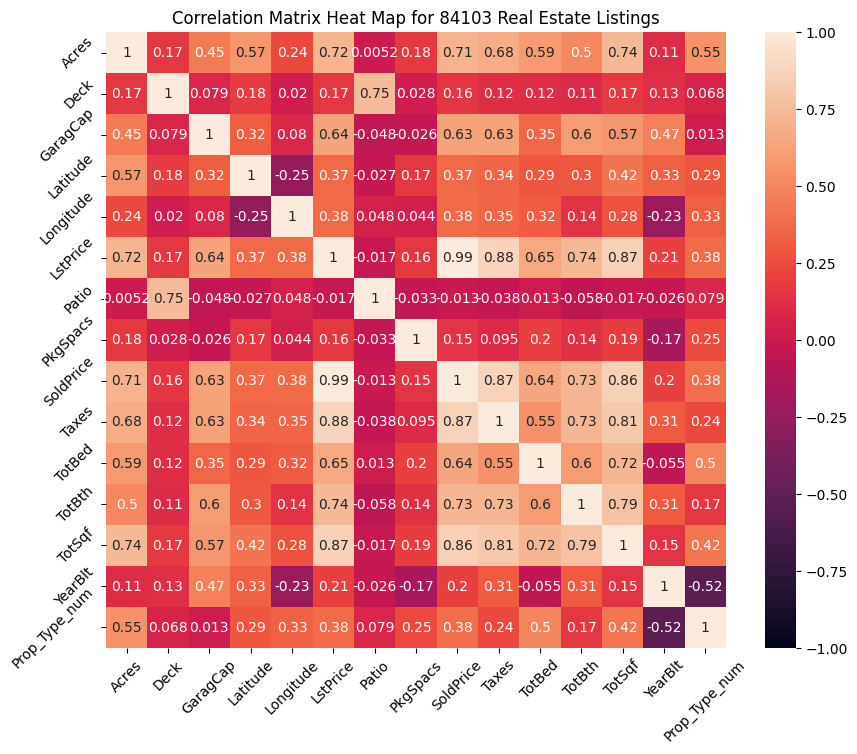

In [88]:
# Get correlation matrix
# We can't calculate the correlation for string types (the issue here is the 'PropType' column)
# So we will drop it in the .corr() operation, but it won't affect the actual df
# axis=0 in .drop() means to operate on rows (1 for columns)

corr_matrix = df.drop('PropType', axis=1).corr()

# Heat map of the correlation matrix using seaborn

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, 
            annot=True, # add the values to the squares
            vmin=-1, 
            vmax=1, 
            cbar=True) # add color bar

plt.title('Correlation Matrix Heat Map for 84103 Real Estate Listings')

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

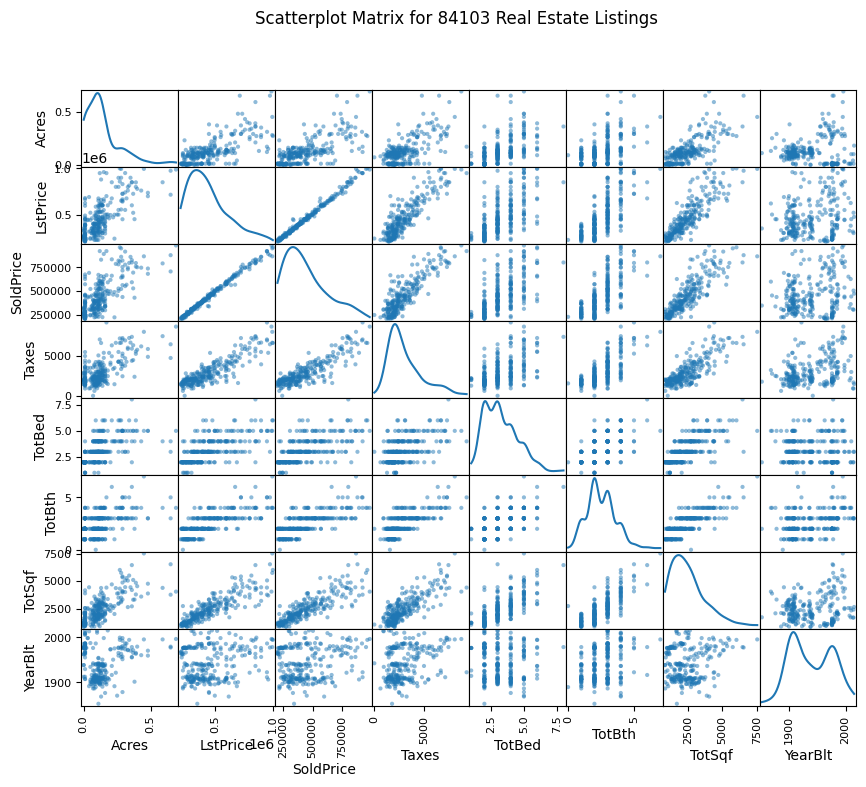

In [89]:
# Scatter plot matrix using pandas.plotting scatter_matrix

list_from_instructions = ['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']

scatter_matrix( df[list_from_instructions], figsize=(10, 8), diagonal='kde' )

plt.suptitle('Scatterplot Matrix for 84103 Real Estate Listings')

plt.show()

#### Response:

**"Describe your findings."**

The strongest negative correlation appears to be between YearBlt and Prop_Type_num, which indicates that older homes tend to be single family homes, whereas nowadays, more and more townhouses and condos are being built (if the listings are indeed indicative of freuquency, which implies being built).

There are some unsurprising things such as Taxes being strongly correlated with Sold/List Price.

Also, for some reason, having a patio seems to have a negative correlation with everything *except* for also having a deck.

Longitude/Latitude also have correlations with YearBuilt, which kind of shows how building throughout the area is sort of spreading northward and westward.

Prop_Type_num and Acres have a decently strong correlation. At first glance, this seems like it should be much stronger, as single family homes would always be larger than condos and townhomes in terms of acreage. However, we are talking in terms of really urban single family homes, and I don't think that the homes in the avenues are on all that large of lots.

Another interesting feature: the data involving list price and YearBuilt is super scattered. To me this makes sense in the avenues though. In suburban areas, where there is lots of renewal and rebuilding and new subdivisions, there is lots of turnover with old homes. Older homes that stick around can sometimes simply be because of nicer subdivisions popping up around them, and the older homes aren't preserved with the intention of keeping them historic. So they go for less. But in the avenues, there are a lot of older, historic, 100-year old homes that have never been surrounded by subdivisions (in a sense) and well-off owners who maintain them really well. So, in summary: in suburbs, I bet there would be a stronger correlation between YearBuilt and ListPrice (older homes sell for less); but in the avenues, older homes are more "historic"-y and hold their value, making for more ambiguous correlation.   

### Task 4: Geospatial plot

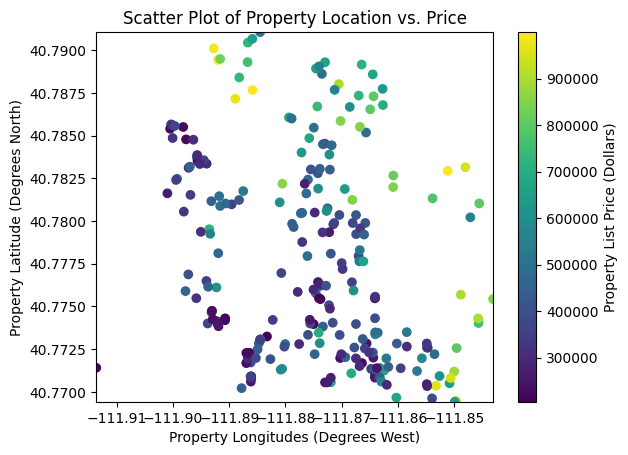

In [90]:
# Create scatterplot

plt.scatter( df['Longitude'], df['Latitude'], c=df['LstPrice'] ) # 1st param is x; 2nd is y

# Add color bar on right side

plt.colorbar( label='Property List Price (Dollars)' )

plt.title('Scatter Plot of Property Location vs. Price')

# x-axis stuff

plt.xlabel('Property Longitudes (Degrees West)')
plt.xlim( df['Longitude'].min(), df['Longitude'].max() ) # intervals between values are tiny, need to scale down

# y-axis stuff

plt.ylabel('Property Latitude (Degrees North)')
plt.ylim( df['Latitude'].min(), df['Latitude'].max() )

plt.show()

#### Response:

**"What can you say about the relation between the location and the house price?"**

 That it seems to go up the more east and the more north you get (the further away from downtown).

### Task 5: Simple Linear Regression

In [91]:
# Y = β_0 + β_1(X)

Y = df['SoldPrice'] # dependent variable
X = sm.add_constant( df['LstPrice'] ) # independent variable

print( sm.OLS( Y, X ).fit().summary() )

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.520e+04
Date:                Fri, 31 May 2024   Prob (F-statistic):          6.30e-257
Time:                        23:49:39   Log-Likelihood:                -2893.0
No. Observations:                 257   AIC:                             5790.
Df Residuals:                     255   BIC:                             5797.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.267e+04   2999.326      4.225      0.0

#### Response:

**"Report the R-squared value for this model (SoldPrice ~ LstPrice) and give an interpretation for its meaning. Also give an interpretation of beta_1 for this model."**

The $R^2$ value is $0.99$ which means that there is a very strong relationship between the two and that list price is going to be a good predictor of sold price.

The $\beta_1$ for list price is $0.9456$, meaning that means that for every increase of $1$ in list price, sold price increases by $0.9456$. This means there is a pretty strong linear relationship between the two, meaning they are strongly correlated, which is what we would expect.

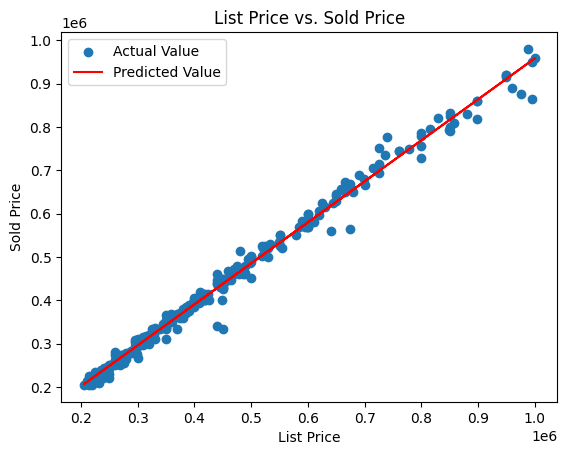

In [92]:
# Plot of list vs. sold prices with regression model overlay

# Plot

plt.scatter(df['LstPrice'], df['SoldPrice'], label='Actual Value')

# Make line using stuff from above and formula

intercept = 1.267e+04
slope = 0.9456

sold_price = intercept + slope * df['LstPrice']

# Overlay the line

plt.plot( df['LstPrice'], sold_price, color='red', label='Predicted Value')

plt.title('List Price vs. Sold Price')
plt.xlabel('List Price')
plt.ylabel('Sold Price')

plt.legend()

plt.show()

### Task 6: Multilinear Regression

In [93]:
# Create new df without the specified columns

predictive_vars = df.drop(['LstPrice', 'PropType', 'Prop_Type_num'], axis=1)

# Define independent/dependent variables

Y = df['SoldPrice']

X = sm.add_constant(predictive_vars)

# Multilinear regression

print( sm.OLS(Y, X).fit().summary() )

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.972e+24
Date:                Fri, 31 May 2024   Prob (F-statistic):               0.00
Time:                        23:49:39   Log-Likelihood:                 3327.6
No. Observations:                 257   AIC:                            -6627.
Df Residuals:                     243   BIC:                            -6577.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.61e-07      0.000      0.001      1.0

#### Response:

**Which variables are the best predictors for the Sold Price?**

- Acres
- Latitude
- Longitude

**Often the price per square foot for a house is advertised. Is this what the coefficient for TotSqf is measuring? Provide an interpretation for the coefficient for TotSqf.**

No, the coefficient for Total Square Footage $1.111e-14$ is not the price per square foot. The coefficients ($\beta$'s) of the predictive variables indicate the correlation between the dependent variable (Sold Price) and an independent variable (the coefficient's term).

**Estimate the value that each Garage space adds to a house.**

The coefficient for Garage Capacity is $7.944e-11$, suggesting that for every $1$ units of garage capacity, SoldPrice increases by $0.00000000007944$ unit. So 794 billionths of a dollar.

**Does latitude or longitude have an impact on house price? Explain.**

Yes. They have (relatively) big coefficients. This means that houses that are further north/east have will tend to have higher prices.

**If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare?**

This model is not good at all. It says that garage capacity is a better predictor of sold price than square footage by three orders of magnitude. I don't know why all the coefficients are so small.

### Task 7: Incorporating a categorical variable

In [94]:
# `SoldPrice = beta_0 + beta_1 * Prop_Type_num`

X = sm.add_constant( df['Prop_Type_num'] )

print( sm.OLS(Y, X).fit().summary() )

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     43.93
Date:                Fri, 31 May 2024   Prob (F-statistic):           2.01e-10
Time:                        23:49:39   Log-Likelihood:                -3464.1
No. Observations:                 257   AIC:                             6932.
Df Residuals:                     255   BIC:                             6939.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           3.25e+05   2.19e+04     14.863

In [95]:
# `SoldPrice = beta_0  + beta_1 * Prop_Type_num + beta_2 * TotSqf`

X = sm.add_constant( df[['Prop_Type_num', 'TotSqf']] )

print( sm.OLS(Y, X).fit().summary() )

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     349.6
Date:                Fri, 31 May 2024   Prob (F-statistic):           1.14e-73
Time:                        23:49:39   Log-Likelihood:                -3314.6
No. Observations:                 257   AIC:                             6635.
Df Residuals:                     254   BIC:                             6646.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.183e+05    1.5e+04      7.862

#### Response:

**"From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when you take into account total square footage, property type is no longer predictive. Explain this. (Hint: there is a confounder lurking here.)"**

As we saw in the heatmap in Task 3, square footage, property type, and list/sold prices are all really strongly correlated.

Additionally we see:
- In the first model, $R^2$ with just the one predictive variable (property type) is 0.147.
- In the second model, $R^2$ with both predictive variables (property type *and* square footage) is 0.734.

So, the explanatory power of just property type was strong in the first model, but, when we mix it with square footage, it goes way down.

This does not mean property type was an erroneous predictor at any point, it's just that the multicollinearity between property value and square footage means that some of the predictive power of the property type is already being explained somewhat by another variable that is not only strongly correlated with list price, but with the other predictive variable (i.e. square footage).

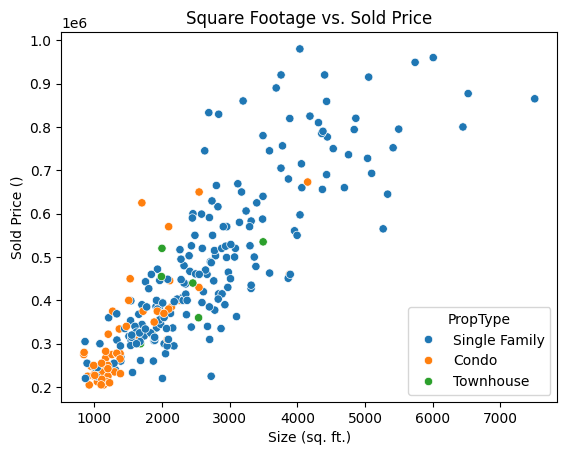

In [96]:
sns.scatterplot(x='TotSqf', y='SoldPrice', hue='PropType', data=df)

plt.title('Square Footage vs. Sold Price')
plt.xlabel('Size (sq. ft.)')
plt.ylabel('Sold Price ()')

plt.show()